# Building Instustrial Deep Learning Solutions

<p style="text-align: center;">Daniele Solombrino <br>
dansolombrino@{gmail.com,GitHub}</p>

## Virtual Environments

First rule of a good coding project: hygiene!

Every project should have its own **Python virtual environment**, so as packages installed for one project do not collide with packages needed by other projects.

Python virtual environments can be created in different ways.

Today, we will use `python venv`, which comes already installed in the latest Python versions (>=3.3)

First, we are going to create the virtual environment, by pasting the following code into the terminal

`python -m venv digits_classification`

Then, we are going to activate the virtual environment by pasting this other line into the terminal

`source digits_classification/bin/activate`

## requirements.txt

Each project requires some Python packages to be installed.

Add them all in the file named `requirements.txt`.

Anytime someone has to replicate your environment, they will simply do a `pip3 install -r requirements.txt` on their machine, after having created and activated the virtual environment.

## The problem

You are handling a client which gave you a problem to solve.

This problem includes the following need: recognize handwritten digits that have been OCR'd from a system the client is already using.

## Data

### Data loading

After some time spent online, you find information about this dataset, which is the closest to the inputs that the client has: [MNIST](https://en.wikipedia.org/wiki/MNIST_database)

You start looking around and you find different sources to get it, including [this](https://www.kaggle.com/datasets/hojjatk/mnist-dataset) Kaggle page and [this](https://github.com/yawen-d/Neural-Network-on-MNIST-with-NumPy-from-Scratch) GitHub repo.

You look at the pages and you find that the GitHub has the files in a much much more convenient way, so you decide to download them from there.

For practicality, the data has been already downloaded for you and are included in this repo.

Remember what we have stated in the previous weeks: never, EVER, trust code coming from other people blindly.

For this reason, we are going to look into the data.

The file is in hdf5 format, which needs its Python lib to be handled correctly.

We add the library to the `requirements.txt` file and install it by doing `pip3 install h5py`

In [1]:
import h5py

In [2]:
MNIST_data = h5py.File('MNISTdata.hdf5', 'r')

Since we have zero trust on whoever provided the data, first and foremost, we are going to see that data is stored inside the archive file.

h5 files can be treated as dictionaries, so the first thing that makes sense is to look at the keys of the archive.

In [3]:
from rich import print # nicer prints

In [4]:
print(MNIST_data.keys())

<KeysViewHDF5 ['x_test', 'x_train', 'y_test', 'y_train']>

### Data splitting

The archive has four Tensors: X_train, X_test, Y_train, Y_test.

A couple of questions for you:

1) Why $X$ and $Y$?
2) Why train and test?

$X$ are the inputs and $Y$ are the outputs, as we are in a supervised setting scenario!

As we stated these weeks, we want Machine/Deep Learning models that generalize to never-seen-before data! <br>
For this reason, we hold a portion of the data out, the test data, to verify our performance on data never seen before!<br>
To be complete, we are also going to get another portion of data not used for training, the "validation" set.<br>
We are going to give more details about test vs. validation it in the appropriate time, for now, we are just going to save the various data splits.

In [5]:
# train data
X_train = MNIST_data['x_train'][:]
Y_train = MNIST_data['y_train'][:]

# test data
X_test = MNIST_data['x_test'][:]
Y_test = MNIST_data['y_test'][:]

In [6]:
print(f"X_train.shape: {X_train.shape}")
print(f"Y_train.shape: {Y_train.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"Y_test.shape: {Y_test.shape}")

X_train.shape: (60000, 784)

Y_train.shape: (60000, 1)

X_test.shape: (10000, 784)

Y_test.shape: (10000, 1)

Do these shapes make sense to you? What do you think these values mean?

$60k$ and $10k$ are the number of data samples in each split.

$768$ is the number of features that each data sample has.

$1$ is the label for each sample

Let's create the additional validation split

In [7]:
X_val = X_train[50000:60000]
Y_val = Y_train[50000:60000]

X_train = X_train[0:50000]
Y_train = Y_train[0:50000]

In [8]:
print(f"X_train.shape: {X_train.shape}")
print(f"Y_train.shape: {Y_train.shape}")
print(f"X_val.shape: {X_val.shape}")
print(f"Y_val.shape: {Y_val.shape}")
print(f"X_test.shape: {X_test.shape}")
print(f"Y_test.shape: {Y_test.shape}")

X_train.shape: (50000, 784)

Y_train.shape: (50000, 1)

X_val.shape: (10000, 784)

Y_val.shape: (10000, 1)

X_test.shape: (10000, 784)

Y_test.shape: (10000, 1)

There is not a fixed rule about the split sizes. The most used values are: 60/20/20, 70/20/10 and 80/10/10 (train %/val %/test %).

In this case, we are using a 70/15/15, as other percentages would've required more operations to be computed.

Hygiene rule: never, EVER, have overlapping data samples between the splits. 

Training data is for training.
Validation data is for validation.
Test data is for testing.

Each split has its own "goal".

### Providing data to models

We have some data in memory, but we still need to have a way of bringing this data to the model that we will use for our predictions.

The framework we are going to use, PyTorch, provides an abstract class, `Dataset`, which we are supposed to specialize.

The abstract class `Dataset` requires the specification of two methods, `init()`, `len()`, and `get_item()`.

The `init()` method simply builds the specialized `Dataset` object, the `len()` method returns the total number of elements in the dataset, while the `get_item()` method is responsible for actually providing data when necessary. 

In [9]:
import torch
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
    def __init__(self, X_data, Y_data):
        """
        Initializes the dataset with features and labels.

        Args:
            X_data (numpy array): The feature data, e.g., images.
            Y_data (numpy array): The labels corresponding to the images.
        """
        self.X_data = X_data  # Store the features
        self.Y_data = Y_data  # Store the labels

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.X_data)

    def __getitem__(self, idx):
        """
        Generates one sample of data.

        Args:
            idx (int): Index of the sample to retrieve.

        Returns:
            tuple: (image, label) where image is the input data and label is the corresponding label.
        """
        # Retrieve the image and label using the index
        image = self.X_data[idx]
        label = self.Y_data[idx]

        # Convert the image and label to PyTorch tensors
        image = torch.tensor(image, dtype=torch.float32)
        label = torch.tensor(label, dtype=torch.long)

        return {
            "image": image, 
            "label": label
        }

Let's now instantiate three `MNISTDataset` objects, one for each split

In [10]:
ds_train = MNISTDataset(X_data=X_train, Y_data=Y_train)
ds_val = MNISTDataset(X_data=X_val, Y_data=Y_val)
ds_test = MNISTDataset(X_data=X_test, Y_data=Y_test)

Let's now try whether they work as expected or not...

In [11]:
print(f"len(ds_train): {len(ds_train)}")
print(f"len(ds_val): {len(ds_val)}")
print(f"len(ds_test): {len(ds_test)}")

len(ds_train): 50000

len(ds_val): 10000

len(ds_test): 10000

In [12]:
image, label = ds_train[0].values()

print(f"image.shape: {image.shape}")
print(f"label.shape: {label.shape}")
print(f"image: {image}")
print(f"label: {label}")

image.shape: torch.Size([784])

label.shape: torch.Size([1])

image: tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0118,
        0.0706, 0.0706, 0.0706, 0.4941, 0.5333, 0.6863, 0.1020, 0.6510, 1.0000,
        0.9686, 0.4980, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1176, 0.1412, 0.3686, 0.6039,
        0.6667, 0.9922, 0.9922, 0.9922, 0.9922, 0.9922, 0.8824, 0.6745, 0.9922,
        0.9490, 0.7647, 0.2510, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1922, 0.9333, 0.9922, 0.9922,
        0.9922, 0.9922, 0.9922, 0.9922, 0.9922, 0.9922, 0.9843, 0.3647, 0.3216,
        0.3216, 0.2196, 0.1529, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0706, 0.8588, 0.9922,
        0.9922, 0.9922, 0.9922, 0.9922, 0.7765, 0.7137, 0.9686, 0.9451, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.3137,
        0.6118, 0.4196, 0.9922, 0.9922, 0.8039, 0.0431, 0.0000, 0.1686, 0.6039,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0549, 0.0039, 0.6039, 0.9922, 0.3529, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.5451, 0.9922, 0.7451, 0.0078, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0431, 0.7451, 0.9922, 0.2745,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.1373, 0.9451,
        0.8824, 0.6275, 0.4235, 0.0039, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.3176, 0.9412, 0.9922, 0.9922, 0.4667, 0.0980, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.1765, 0.7294, 0.9922, 0.9922, 0.5882, 0.1059, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0

label: tensor([5])

Let's do some sanity checks...

Iterate through the entire dataset

In [13]:
for x in ds_train:
    image, label = x.values()
    pass

for x in ds_val:
    image, label = x.values()
    pass

for x in ds_test:
    image, label = x.values()
    pass

And let's look at some samples...

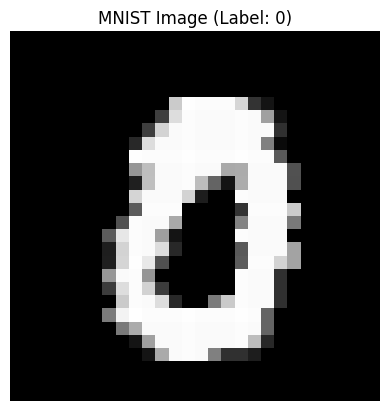

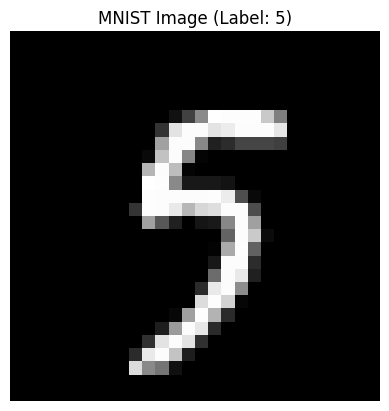

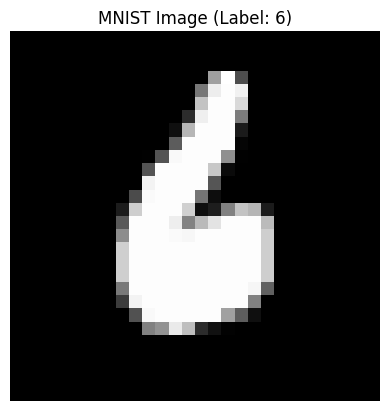

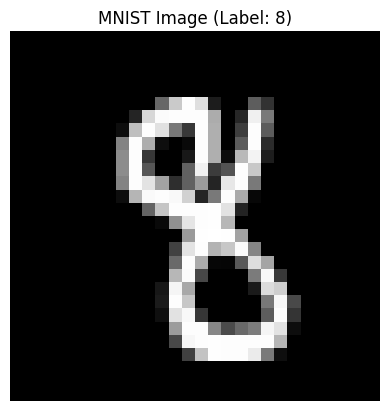

In [14]:
import torch
import matplotlib.pyplot as plt

for idx in [69, 420, 1337, -1]:
    image, label = ds_train[idx].values()

    # Reshape the image tensor to a 28x28 matrix
    image = image.view(28, 28)

    # Plot the image using matplotlib
    # The image is in grayscale, so we use the 'gray' colormap
    plt.imshow(image.numpy(), cmap='gray')
    # Add a title with the label of the image
    plt.title(f'MNIST Image (Label: {label.item()})')
    # Hide the axes for better visualization
    plt.axis('off')
    # Display the plot
    plt.show()

Notice that we had to reshape data.

The dataset has flattened the 2D images into 1D vectors, but plotting them requires them to be in their natural shape.

Familiarize with the concept of reshaping, as it will be crucial for Deep Learning practitioners!

The `MNISTDataset` class is the first data-related component that we need.

The second one is a `DataLoader` instance.

The DataLoader is the object actually responsible for loading data from the disk and getting it ready for the model to use.

The DataLoader also solves a very important need in Deep Learning: data batching.

When we talked about Gradient Descent, we skipped an important detail: how many data samples are needed to perform a parameter update?

Classic Gradient Descent requires all data to be taken into consideration, but it is impossible due to memory constraints.

For these reasons, Stochastic Gradient Descent (SGD) is the most used version of GD, where the update is performed after having seen just a bunch (a batch, or mini-batch!) of data!

Getting a DataLoader is as simple as instantiating its PyTorch object.

The main parameters to pass to a DataLoader are:
- the dataset itself
- the batch size, i.e. the number of elements that are required to perform the parameter update
- whether to shuffle the data or not

Shuffling the data is extremely important during training and it can be avoided at validation and test time.

Why?

Remember: Deep Learning models will try to cheat as much as possible, and one possible cheating may be the memorization of the data position in the dataset (e.g. the second element is always an 8? The model will memorize this and not look at the actual contents of the data)


In [15]:
BATCH_SIZE = 64

In [16]:
from torch.utils.data import DataLoader

train_loader = DataLoader(ds_train, batch_size=BATCH_SIZE, shuffle=True)

val_loader = DataLoader(ds_val, batch_size=BATCH_SIZE, shuffle=False)

test_loader = DataLoader(ds_test, batch_size=BATCH_SIZE, shuffle=False)

Let's compare iterating on the MNISTDataset vs. iterating on the DataLoader

In [17]:
for x in ds_train:
    image, label = x.values()
    print(f"image.shape: {image.shape}")
    break

image.shape: torch.Size([784])

In [18]:
for x in train_loader:
    image, label = x['image'], x['label']
    print(f"image.shape: {image.shape}")
    break

image.shape: torch.Size([64, 784])

Can you spot the difference?

One iteration on the DataLoader gets us a batch of data, while an iteration on the MNISTDataset gets us one single element.

## Model

After having dealt with data, it's time to build the actual Deep Learning model.

In this first attempt, we are going to use a Convolutional Neural Network (CNN), deeping the discussion about it that we started in the previous weeks.

Similarly to the dataset approach, coding a Deep Learning model in PyTorch requires the specialization of an abstract class, the `Module` class inside the `torch.nn` package.

Our implementation must specialize the `init()` method, which builds the model object, and the `forward()` method, which is used any time we want to get a prediction out of our model.

As seen in the previous weeks, the to get a prediction from a generic Neural Network with three layers, assuming $x$ is our input, we simply have to perform 

$$
\begin{align*}
x &= \text{layer}_1(x) \\
x &= \text{layer}_2(x) \\
x &= \text{layer}_3(x)
\end{align*}
$$

In the next cell, we are going to code the model. After that, we are going to discuss some coding details that we have not yet introduced in the past weeks.

In [19]:
from torch import nn
import torch.nn.functional as F

# Define the CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # First convolutional layer: input channels = 1 (grayscale), output channels = 32, kernel size = 3x3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # Second convolutional layer: input channels = 32, output channels = 64, kernel size = 3x3
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # Third convolutional layer: input channels = 64, output channels = 128, kernel size = 3x3
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # Fully connected layer: input features = 128 * 3 * 3, output features = 10 (number of classes)
        self.fc1 = nn.Linear(in_features=128 * 3 * 3, out_features=10)

    def forward(self, x, verbose=False, print=print):
        if verbose: print(f"#################### Input ####################")
        if verbose: print(f"Input shape: {x.shape}")
        if verbose: print(f"#################### Input ####################")

        # Apply first convolutional layer followed by ReLU activation and max pooling
        if verbose: print(f"#################### Conv block 1 ####################")
        x = self.conv1(x)
        if verbose: print(f"after self.conv1 shape: {x.shape}")
        x = F.relu(x)
        if verbose: print(f"after ReLU shape: {x.shape}")
        x = F.max_pool2d(x, 2, 2)
        if verbose: print(f"after max pool shape: {x.shape}")
        if verbose: print(f"#################### Conv block 1 ####################")
        
        # Apply second convolutional layer followed by ReLU activation and max pooling
        if verbose: print(f"#################### Conv block 2 ####################")
        x = self.conv2(x)
        if verbose: print(f"after self.conv2 shape: {x.shape}")
        x = F.relu(x)
        if verbose: print(f"after ReLU shape: {x.shape}")
        x = F.max_pool2d(x, 2, 2)
        if verbose: print(f"after max pool shape: {x.shape}")
        if verbose: print(f"#################### Conv block 2 ####################")
        
        # Apply third convolutional layer followed by ReLU activation and max pooling
        if verbose: print(f"#################### Conv block 3 ####################")
        x = self.conv3(x)
        if verbose: print(f"after self.conv3 shape: {x.shape}")
        x = F.relu(x)
        if verbose: print(f"after ReLU shape: {x.shape}")
        x = F.max_pool2d(x, 2, 2)
        if verbose: print(f"after max pool shape: {x.shape}")
        if verbose: print(f"#################### Conv block 3 ####################")

        # Flatten the tensor into a vector for the fully connected layer
        if verbose: print(f"#################### Output ####################")
        x = x.view(-1, 128 * 3 * 3)
        if verbose: print(f"after flatten shape: {x.shape}")
        
        # Apply the fully connected layer
        x = self.fc1(x)
        if verbose: print(f"after fc1 shape: {x.shape}")
        if verbose: print(f"#################### Output ####################")
        
        # Apply softmax to get probabilities
        return x

First, let's do some sanity checks

A very first thing to do is to print the actual model, in order to get insights about the various layers.

In [20]:
model = SimpleCNN()

print(model)

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=10, bias=True)
)

Always get an idea of the number of trainable parameters that your model has.

In [21]:
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

104202

Another good test regards the shape of your input as it progresses through the Network. The prints in the `forward()` method 

In [22]:
# the dataloader is an iterator, so we need to call next to get the a batch
# the batch is a dictionary with the keys 'image' and 'label', each containing a tensor
x = next(iter(train_loader))['image']

# this is how we get a prediction from the model.
try:
    y = model.forward(x, verbose=True)
except Exception as e:
    print(f"Caught an error: [red bold]{e}")

#################### Input ####################

Input shape: torch.Size([64, 784])

#################### Input ####################

#################### Conv block 1 ####################

Caught an error: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [64, 784]

Shape of your data and shape required by your model rarely match.

In this case, the Convolutional layer expects a 2D (batched) input of shape $[\text{ batch size }, \text{ channels }, \text{ height }, \text{ width }]$.

In these examples, batch size is $8$, channels is $1$, as we are dealing with greyscale images (in RGB, it would've been $3$), and height and width is $28$

Let's try again, this time with the correct input shape

In [23]:
x: torch.Tensor = next(iter(train_loader))['image']

x = x.view(-1, 1, 28, 28)

try:
    y = model.forward(x, verbose=True)
except Exception as e:
    print(f"Caught an error: {e}")

#################### Input ####################

Input shape: torch.Size([64, 1, 28, 28])

#################### Input ####################

#################### Conv block 1 ####################

after self.conv1 shape: torch.Size([64, 32, 28, 28])

after ReLU shape: torch.Size([64, 32, 28, 28])

after max pool shape: torch.Size([64, 32, 14, 14])

#################### Conv block 1 ####################

#################### Conv block 2 ####################

after self.conv2 shape: torch.Size([64, 64, 14, 14])

after ReLU shape: torch.Size([64, 64, 14, 14])

after max pool shape: torch.Size([64, 64, 7, 7])

#################### Conv block 2 ####################

#################### Conv block 3 ####################

after self.conv3 shape: torch.Size([64, 128, 7, 7])

after ReLU shape: torch.Size([64, 128, 7, 7])

after max pool shape: torch.Size([64, 128, 3, 3])

#################### Conv block 3 ####################

#################### Output ####################

after flatten shape: torch.Size([64, 1152])

after fc1 shape: torch.Size([64, 10])

#################### Output ####################

What can we observe from this progression of input shapes?

- the batch size ($8$, the first Tensor dimension) remains always the same.
- the channel dimension (second Tensor dimension) gets progressively larger.
- the spatial dimensions (third and fourth Tensor dimensions) get progressively smaller.

The last two points are typical of CNNs. Spatial dimensionalities get smaller and smaller and the channels grow more and more.

Why, tho?

The spatial dimensionality reduction is needed, as we need to map large inputs (e.g. 1MP images or 2 mins long audios) to small outputs (e.g. ten class values or one single float value).

As far as the channel is concerned, think about one single channel one "feature" that the Network is aware of (e.g. image edges, colors, orientations, or a pattern).
The more types of features the NN knows, the better (in theory, up to a limit, outside of the scope of these talks). 

Before moving on to the actual training, we have two components we need to talk about: `max_pool2d()` and `relu()`.

### Pooling

Pooling is the operation that helps with spatial dimensionality reduction.

![Alt text](images/MaxpoolSample2.png)

The spatial dimensionality reduction fron convolutions alone would require too many layers or filters/kernels too big, so pooling is a very effective way of achieving this goal.

"max" stands for "maximum", meaning that for each $n \times n$ region we take the maximum value. Other possible operators are min and average.

The kind of pooling to use and its dimension are two hyperparameters of CNNs and depend on the goal we want to achieve.


### Nonlinearities

Up until now, we have talked about linear mappings, which can approximate linear phenomena.

What about nonlinear phenomena? In such cases, a linear mapping can not do a proper job, so the addition of nonlinearities can be a huge boosts.

In Neural Network terms, nonlinearities are also called "activation functions" or simply "activations". Their goal is to process data in a nonlinear way, so as the Network is capable of handling nonliner trasnformation of the data.

`relu()` implements the "Rectified Linear Unit" nonlinear activation function, and it is just one of the many possible choices.

![Alt text](images/activation_fns.jpeg)

The choice of which activation function to use is a hyperparameter of a NN and it can have important impacts on your performance.

As we can see from the shapes printed in the `forward()` method, the activation function is applied element-wise, as it does not change the dimensionality of the Tensor.

## Training

We are now ready to train our CNN!

This section will guide you towards coding all the needed additional bits.

Let's recap what we have up to this point: datasets and dataloaders for train, val and test, and the model.

### Training loop

The very first component that we need to code is a train loop. Why loop, tho?

As we have stated before, we are going to use SGD, which updates the model parameters after having seen a bunch (a batch!) of data (8 samples, in our case).

For this reason, we need to loop over all the batches to expose our model to all of our data samples. When we complete one of such loop, we say that we completed an "epoch".

The number of epochs (i.e. the number of times that our model has seen the entire dataset) is a hyperparameter.

### Loss

During our talks, we have cited multiple time the fact that Deep Learning basically minimizes an error, usually referred to as "loss".

What is the loss, in this classification case?

If you scroll back up, you can see that our model outputs a Tensor of shape $[ \text{batch size}, \text{number of classes} ]$.

What is that vector of dimension $\text{number of classes}$?

For each class, the model predicts the probability that the input belongs to that class. To be precise, without an extra step, which we will see in the code, the output is not a proper probability distribution, rather, it is a logit distribution.
Logits convey the same information of a probability distribution, but they are normalized so as to sum up to $1$ and to be all non-negatives.

Let's assume that the model outputs the following logit distribution for the $3\text{rd}$ sample of the batch: 

$$y_ \text{pred} = [0.1, -1.2, 0.5, -0.4, 0.3, -0.8, 5.7, 0.2, -0.5, 0.1]$$

Let's also assume that our ground truth output is

$$ y_\text{gt} = 6 $$

What can we notice?

- the model did indeed predict the right digit
- but we need a way to tell it to it!

How would you tell the model whether it output the right (or wrong!) prediction?

One possibility is to turn that $\text{y\_pred}$ into one single value and take the distance with $\text{y\_gt}$.

But... it would not make much sense for different reasons.
The most important of them being that the gt value and the logits are two different kinds of data and turning the logits into a single scalar value destroys their structure.

However, the inverse operation is not destructive! We can easily turn the gt value into a logit using "one-hot" vectors, where we have all zeroes except a one in the position of the value that we want to encode. In this case, we'd get:

$$ y_{\text{gt}_\text{onehot}} = [0, 0, 0, 0, 0, 0, 1, 0, 0, 0]$$

Since $y_\text{pred}$ and $ y_{\text{gt}_\text{onehot}}$ are both vectors with $10$ elements, we can now try to push our predictions to be as similar as possible to the ground truth, one-hot vector!

![Alt text](images/kl_div.png)

One possible loss that does this is the "Cross-Entropy" loss, which has its own PyTorch object and can be easily init'd by doing as follows

In [24]:
criterion: torch.nn.Module = nn.CrossEntropyLoss()

### Optimizer

Now that we know how to compute the error, we need to actually minimize it!

The optimizer is the one that can do it for us, removing the burden of implementing the entire optimization process on our own!

In this example, we are goind to use the simplest possible optimizer, the one that implements SGD as is.

To nobody's surprise, each optimizer has its own PyTorch object, which can be init'd as follows.

In [25]:
from torch import optim

LR = 0.001
optimizer: optim.Optimizer = optim.SGD(model.parameters(), lr=LR)

What is that "LR" parameter?

It is the learning rate, which controls "how much" of the update that the optimizer suggests to apply to actually apply.

Suppose the optimizer tells you to change a prameter by $v$. Applying an update of $\alpha v$ instead of simply $v$ allows us to choose how much of that update to actually use.

This is extremely useful to avoid overshooting, but it may also lead to undershooting.

![Alt text](images/lr.webp)

The learning rate is a hyperparameter of the NN.

### Training loop - continued

Since we have all components needed for a (hopefully successful!) training, we can now fiannly implement the loop, putting all pieces together!

In [26]:
from rich.progress import *
from rich.style import Style
from rich.console import Console

def get_pbar(console: Console) -> Progress:
    pbar = Progress(
        SpinnerColumn(spinner_name="monkey"),
        TextColumn("[progress.description]{task.description}"),
        TextColumn("[bold][progress.percentage]{task.percentage:>3.2f}%"),
        BarColumn(finished_style=Style(color="#008000")),
        MofNCompleteColumn(),
        TextColumn("[bold]•"),
        TimeElapsedColumn(),
        TextColumn("[bold]•"),
        TimeRemainingColumn(),
        TextColumn("[bold #5B4328]{task.speed} it/s"),
        SpinnerColumn(spinner_name="moon")
    )

    return pbar

In [27]:
def train_loop(
    model: SimpleCNN, 
    criterion: nn.Module, 
    optimizer: optim.Optimizer, 
    train_loader: DataLoader, 
    device: torch.device,
    epochs: int, 
    pbar: Progress,
    pbar_tasks: dict,
    verbose: bool = False
):
    model.to(device)
    pbar.reset(pbar_tasks['epoch'])

    # Lists to store loss and accuracy for plotting later
    batch_losses = []
    batch_accuracies = []
    epoch_losses = []
    epoch_accuracies = []

    # Iterate over epochs
    for epoch in range(epochs):
        
        # Training
        model.train()
        
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0

        pbar.reset(pbar_tasks['train_batches'])
        
        for batch_idx, batch in enumerate(train_loader):
            
            # Get the input data and labels
            x, y_true = batch['image'], batch['label']
            x, y_true = x.to(device), y_true.to(device)
            
            # Reshape the input data if necessary
            x = x.view(-1, 1, 28, 28)
            
            # Forward pass
            y_pred = model.forward(x, verbose=False, print=console.print)
         
            # Compute the loss
            y_true = y_true.squeeze()
            loss = criterion(y_pred, y_true)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Backward pass
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            # Update loss and accuracy
            epoch_loss += loss.item()
            
            _, predicted = torch.max(y_pred, 1)
            epoch_total += y_true.size(0)
            epoch_correct += (predicted == y_true).sum().item()
            
            # Log loss and accuracy for plotting later
            batch_losses.append(loss.item())
            batch_accuracy = (predicted == y_true).sum().item() / y_true.size(0)
            batch_accuracies.append(batch_accuracy)
                
            # Update the progress bar
            pbar.advance(pbar_tasks['train_batches'], 1)

        # Calculate average loss and accuracy for the epoch
        avg_loss = epoch_loss / len(train_loader)
        accuracy = epoch_correct / epoch_total
        
        # Record epoch loss and accuracy
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)

        # Print epoch summary
        if verbose:
            console.print(f'Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')

        pbar.advance(pbar_tasks['epoch'], 1)

    return batch_losses, batch_accuracies, epoch_losses, epoch_accuracies

In [28]:
EPOCHS = 3
verbose = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda

In [29]:
console = Console()

pbar = get_pbar(console)

train_epoch_task = pbar.add_task("[bold green]Training epoch...", total=EPOCHS)
train_batches_task = pbar.add_task("[bold violet]Train batches...", total=len(train_loader))  

pbar_tasks = {
    "epoch": train_epoch_task,
    "train_batches": train_batches_task
}

pbar.start()

Output()

In [30]:
batch_losses, batch_accuracies, epoch_losses, epoch_accuracies = train_loop(
    model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    train_loader=train_loader, 
    device=device,
    epochs=EPOCHS, 
    pbar=pbar, pbar_tasks=pbar_tasks, 
    verbose=verbose
)

Epoch [1/3], Loss: 2.2944, Accuracy: 0.1127

Epoch [2/3], Loss: 2.2682, Accuracy: 0.2494

Epoch [3/3], Loss: 2.2200, Accuracy: 0.4082

In [31]:
console.print(len(batch_losses))
console.print(len(batch_accuracies))

2346

2346

In [32]:
console.print(len(epoch_losses))
console.print(len(epoch_accuracies))

3

3

Let's monitor the behaviour of our losses and accuracies during the training

In [33]:
import matplotlib.pyplot as plt

def plot_training_metrics(losses, accuracies, batches_or_epochs):
    """
    Plots the training loss and accuracy over batches.

    Args:
    - losses (list of float): List of loss values recorded during training.
    - accuracies (list of float): List of accuracy values recorded during training.
    """
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss')
    plt.xlabel(f'{batches_or_epochs}')
    plt.ylabel('Loss')
    plt.title(f'Loss over {batches_or_epochs}')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy')
    plt.xlabel(f'{batches_or_epochs}')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy over {batches_or_epochs}')
    plt.legend()

    plt.show()

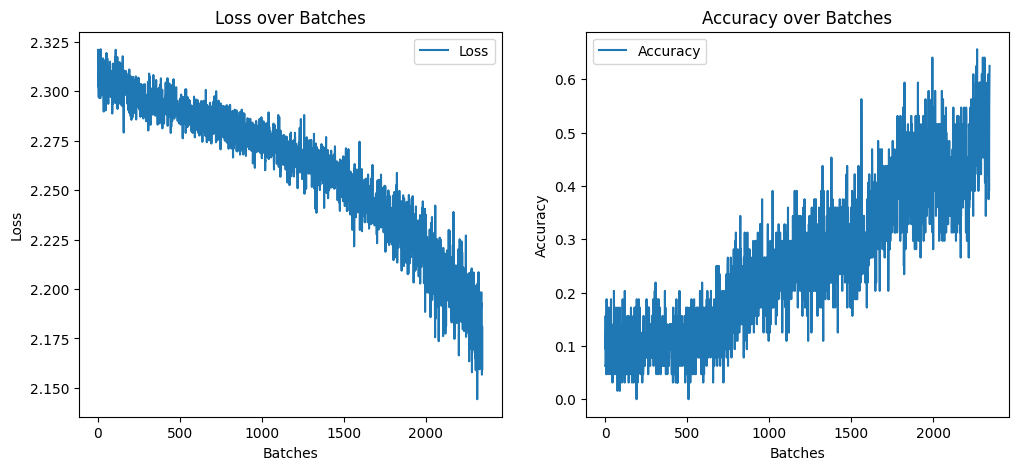

In [34]:
plot_training_metrics(batch_losses, batch_accuracies, "Batches")

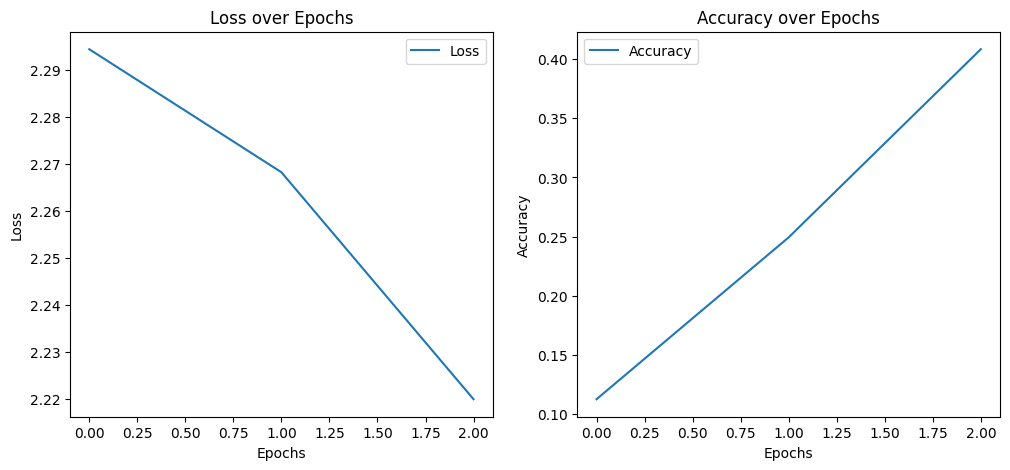

In [35]:
plot_training_metrics(epoch_losses, epoch_accuracies, "Epochs")

Great! Our model achieves acceptable accuracy!

Is this a good result?

Yes*****


### Evaluating generalization

Why the asterisks?

We do not know (yet) how our model performs on never seen before data! In that case, we may have a performance of $10\%$, would not be very good!

Let's add a testing method

In [36]:
def test_loop(
    model: SimpleCNN, 
    criterion: nn.Module, 
    test_loader: DataLoader, 
    device: torch.device,
    pbar: Progress,
    pbar_tasks: dict,
    verbose: bool = False
):
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    # Lists to store loss and accuracy for plotting later
    batch_losses = []
    batch_accuracies = []
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    pbar.reset(pbar_tasks['test_batches'])

    with torch.no_grad():  # Disable gradient calculation
        for batch_idx, batch in enumerate(test_loader):

            # Get the input data and labels
            x, y_true = batch['image'], batch['label']
            x, y_true = x.to(device), y_true.to(device)
            
            # Reshape the input data if necessary
            x = x.view(-1, 1, 28, 28)
            
            # Forward pass
            y_pred = model.forward(x, verbose=False, print=console.print)
         
            # Compute the loss
            y_true = y_true.squeeze()
            loss = criterion(y_pred, y_true)
            
            # Update loss and accuracy
            test_loss += loss.item()
            
            _, predicted = torch.max(y_pred, 1)
            test_total += y_true.size(0)
            test_correct += (predicted == y_true).sum().item()
            
            # Log loss and accuracy for plotting later
            batch_losses.append(loss.item())
            batch_accuracy = (predicted == y_true).sum().item() / y_true.size(0)
            batch_accuracies.append(batch_accuracy)
                
            # Update the progress bar
            pbar.advance(pbar_tasks['test_batches'], 1)

    # Calculate average loss and accuracy for the test dataset
    avg_loss = test_loss / len(test_loader)
    accuracy = test_correct / test_total
    
    # Print summary
    if verbose:
        console.print(f'Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}')

    return batch_losses, batch_accuracies, avg_loss, accuracy

Let's add support for the progress bar...

In [37]:
pbar.stop()

pbar = get_pbar(console)

test_batches_task = pbar.add_task("[bold blue]Test batches...", total=len(train_loader))  

pbar_tasks["test_batches"] = test_batches_task

pbar.start()

Output()

In [38]:
batch_test_losses, batch_test_accuracies, avg_test_loss, test_accuracy = test_loop(
    model, criterion, test_loader, device=device, pbar=pbar, pbar_tasks=pbar_tasks, verbose=True
)

Test Loss: 2.1753, Test Accuracy: 0.5215

GG!

We have extremely high performance in the test data too! That's a very good sign.

Don't get accustomed to this, it's a very rare case in Deep Learning!

### Validation loop

Un top this moment, we have used two of the three splits: train and test.

What about validation?

In cases like this, we did not have to change any kind of hyperparameter: we choose a bunch of them and they resulted in very good performance.

In cases where the choice is not so good, we have to perform what is called "hyperparameter tuning", i.e. a trial and error process where we tweak the params a little bit and see what happens.

To verify the goodness of our change, we need to use the validation test.

After every epoch, we validate on the validation test to see how the loss and the accuracy is going, as far as never-seen-before data is concerned.

We can add support for the validation with minimal changes to the train and test methods.

Specifically, the test method can be used as is, while the training method needs just some small changes to call that test method (on the validation data, tho, NOT on the test data!)

In [39]:
def test_loop(
    model: SimpleCNN, 
    criterion: nn.Module, 
    test_loader: DataLoader, 
    device: torch.device,
    pbar: Progress,
    pbar_tasks: dict,
    val_or_test: str,
    verbose: bool = False
):
    model.to(device)
    model.eval()  # Set the model to evaluation mode

    # Lists to store loss and accuracy for plotting later
    batch_losses = []
    batch_accuracies = []
    test_loss = 0.0
    test_correct = 0
    test_total = 0

    pbar.reset(pbar_tasks[f'{val_or_test}_batches'])

    with torch.no_grad():  # Disable gradient calculation
        for batch_idx, batch in enumerate(test_loader):

            # Get the input data and labels
            x, y_true = batch['image'], batch['label']
            x, y_true = x.to(device), y_true.to(device)
            
            # Reshape the input data if necessary
            x = x.view(-1, 1, 28, 28)
            
            # Forward pass
            y_pred = model.forward(x, verbose=False, print=console.print)
         
            # Compute the loss
            y_true = y_true.squeeze()
            loss = criterion(y_pred, y_true)
            
            # Update loss and accuracy
            test_loss += loss.item()
            
            _, predicted = torch.max(y_pred, 1)
            test_total += y_true.size(0)
            test_correct += (predicted == y_true).sum().item()
            
            # Log loss and accuracy for plotting later
            batch_losses.append(loss.item())
            batch_accuracy = (predicted == y_true).sum().item() / y_true.size(0)
            batch_accuracies.append(batch_accuracy)
                
            # Update the progress bar
            pbar.advance(pbar_tasks[f'{val_or_test}_batches'], 1)

    # Calculate average loss and accuracy for the test dataset
    avg_loss = test_loss / len(test_loader)
    accuracy = test_correct / test_total
    
    # Print summary
    if verbose:
        console.print(f'{val_or_test.capitalize()} Loss: {avg_loss:.4f}, {val_or_test.capitalize()} Accuracy: {accuracy:.4f}')

    return batch_losses, batch_accuracies, avg_loss, accuracy

In [40]:
def train_loop(
    model: SimpleCNN, 
    criterion: nn.Module, 
    optimizer: optim.Optimizer, 
    train_loader: DataLoader, 
    val_loader: DataLoader,
    device: torch.device,
    epochs: int, 
    pbar: Progress,
    pbar_tasks: dict,
    verbose: bool = False
):
    model.to(device)
    pbar.reset(pbar_tasks['epoch'])


    # Lists to store loss and accuracy for plotting later
    batch_losses = []
    batch_accuracies = []
    epoch_losses = []
    epoch_accuracies = []
    val_epoch_losses = []
    val_epoch_accuracies = []

    # Iterate over epochs
    for epoch in range(epochs):
        
        # Training
        model.train()
        
        epoch_loss = 0.0
        epoch_correct = 0
        epoch_total = 0

        pbar.reset(pbar_tasks['train_batches'])
        
        for batch_idx, batch in enumerate(train_loader):
            
            # Get the input data and labels
            x, y_true = batch['image'], batch['label']
            x, y_true = x.to(device), y_true.to(device)
            
            # Reshape the input data if necessary
            x = x.view(-1, 1, 28, 28)
            
            # Forward pass
            y_pred = model.forward(x, verbose=False, print=console.print)
         
            # Compute the loss
            y_true = y_true.squeeze()
            loss = criterion(y_pred, y_true)
            
            # Zero the gradients
            optimizer.zero_grad()
            
            # Backward pass
            loss.backward()
            
            # Update the weights
            optimizer.step()
            
            # Update loss and accuracy
            epoch_loss += loss.item()
            
            _, predicted = torch.max(y_pred, 1)
            epoch_total += y_true.size(0)
            epoch_correct += (predicted == y_true).sum().item()
            
            # Log loss and accuracy for plotting later
            batch_losses.append(loss.item())
            batch_accuracy = (predicted == y_true).sum().item() / y_true.size(0)
            batch_accuracies.append(batch_accuracy)
                
            # Update the progress bar
            pbar.advance(pbar_tasks['train_batches'], 1)

        # Calculate average loss and accuracy for the epoch
        avg_loss = epoch_loss / len(train_loader)
        accuracy = epoch_correct / epoch_total
        
        # Record epoch loss and accuracy
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(accuracy)

        # Validation step
        val_batch_losses, val_batch_accuracies, avg_val_loss, val_accuracy = test_loop(
            model, criterion, val_loader, device, pbar, pbar_tasks, val_or_test="val", verbose=verbose
        )
        val_epoch_losses.append(avg_val_loss)
        val_epoch_accuracies.append(val_accuracy)

        # Print epoch summary
        if verbose:
            console.print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_loss:.4f}, Train Accuracy: {accuracy:.4f}, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        pbar.advance(pbar_tasks['epoch'], 1)

    return batch_losses, batch_accuracies, epoch_losses, epoch_accuracies, val_epoch_losses, val_epoch_accuracies

In [41]:
model = SimpleCNN()

LR = 0.001
optimizer = optim.SGD(model.parameters(), lr=LR)

criterion = nn.CrossEntropyLoss()

In [42]:
pbar.stop()

pbar = get_pbar(console)

train_epoch_task = pbar.add_task("[bold green]Training epoch...", total=EPOCHS)
train_batches_task = pbar.add_task("[bold violet]Train batches...", total=len(train_loader))  
val_batches_task = pbar.add_task("[bold red]Val batches...", total=len(val_loader))  
test_batches_task = pbar.add_task("[bold blue]Test batches...", total=len(test_loader))  

pbar_tasks = {
    "epoch": train_epoch_task,
    "train_batches": train_batches_task,
    "val_batches": val_batches_task,
    "test_batches": test_batches_task
}

pbar.start()

Output()

In [43]:
batch_losses, batch_accuracies, epoch_losses, epoch_accuracies, val_epoch_losses, val_epoch_accuracies = train_loop(
    model, criterion, optimizer, train_loader, val_loader, device=device, epochs=EPOCHS, 
    pbar=pbar, pbar_tasks=pbar_tasks, verbose=verbose
)

Val Loss: 2.2892, Val Accuracy: 0.1441

Epoch [1/3], Train Loss: 2.2967, Train Accuracy: 0.1057, Val Loss: 2.2892, Val Accuracy: 0.1441

Val Loss: 2.2681, Val Accuracy: 0.3429

Epoch [2/3], Train Loss: 2.2794, Train Accuracy: 0.2195, Val Loss: 2.2681, Val Accuracy: 0.3429

Val Loss: 2.2282, Val Accuracy: 0.5084

Epoch [3/3], Train Loss: 2.2512, Train Accuracy: 0.4245, Val Loss: 2.2282, Val Accuracy: 0.5084

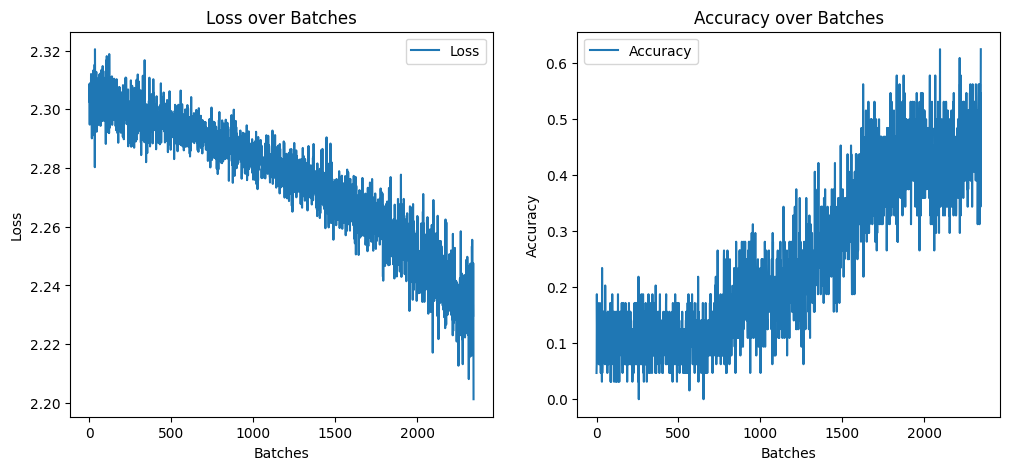

In [44]:
plot_training_metrics(batch_losses, batch_accuracies, "Batches")

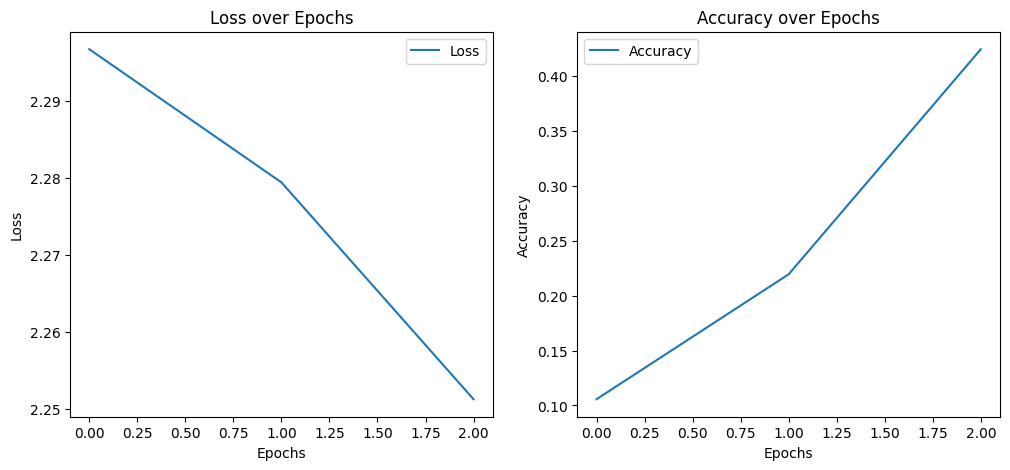

In [45]:
plot_training_metrics(epoch_losses, epoch_accuracies, "Epochs")

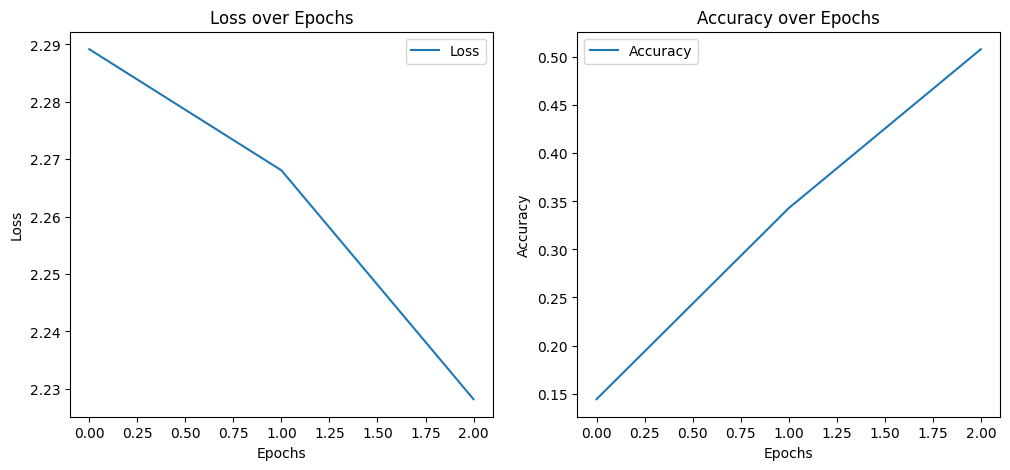

In [46]:
plot_training_metrics(val_epoch_losses, val_epoch_accuracies, "Epochs")